In [1]:
import numpy as np
import dask.array as da

In [2]:
np_arr = np.random.randint(20, size=20)
np_arr

array([10, 17,  7, 11, 13, 10,  6, 14,  0,  8, 15, 12,  5, 19,  9, 16, 11,
        3, 12,  9])

### 要使用Dask Array, 只需在後面多加一項`chunks`

In [3]:
dask_arr = da.random.randint(20, size=20, chunks=5)

### Dask使用 lazy evaluation，因此不會直接出現結果

In [4]:
dask_arr

dask.array<randint, shape=(20,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

### 需要使用 `compute()` 來呈現運算結果

In [5]:
dask_arr.compute()

array([ 4, 16,  0, 17,  0, 15, 10,  2, 19, 15, 12, 13, 11, 11,  8,  5,  5,
       12,  2, 15])

### Chunks size 

In [6]:
dask_arr.chunks

((5, 5, 5, 5),)

### 將np_arr轉為dask_arr

In [7]:
dask_arr_from_np = da.from_array(np_arr, chunks=5)

In [8]:
dask_arr_from_np

dask.array<array, shape=(20,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

In [9]:
dask_arr_from_np.compute()

array([10, 17,  7, 11, 13, 10,  6, 14,  0,  8, 15, 12,  5, 19,  9, 16, 11,
        3, 12,  9])

## Dask 可以先將運算流程圖呈現

#### See : http://docs.dask.org/en/latest/graphviz.html

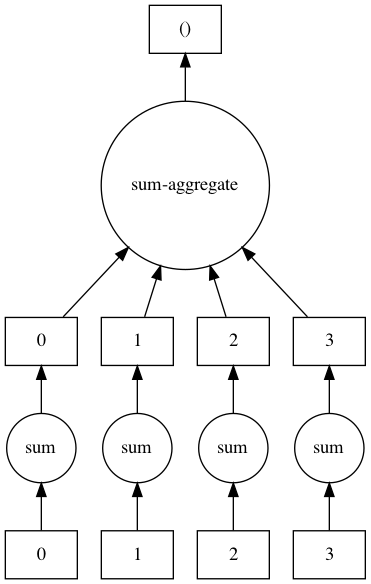

In [10]:
dask_arr_from_np.sum().visualize()

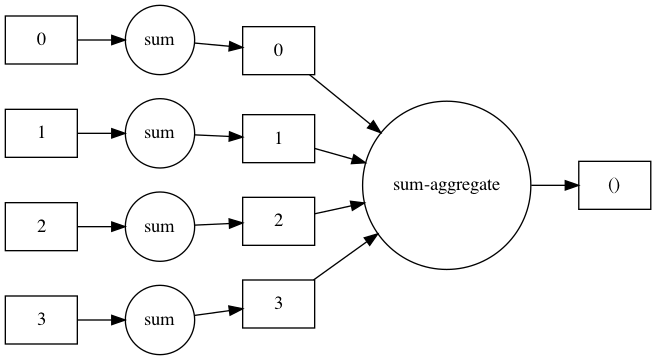

In [11]:
dask_arr_from_np.sum().visualize(rankdir="LR")

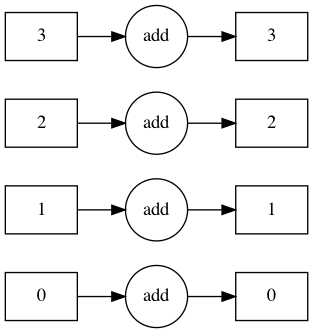

In [12]:
(dask_arr_from_np+1).visualize(rankdir="LR")

In [13]:
dask_arr_mean = da.mean(dask_arr_from_np)
dask_arr_mean.compute()

10.35

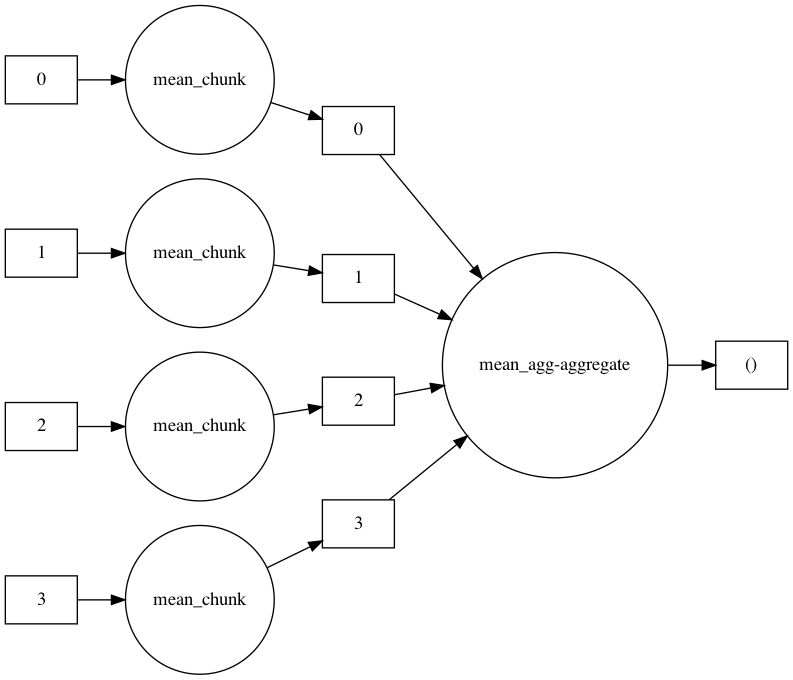

In [14]:
dask_arr_mean.visualize(rankdir="LR")

## Another Example

In [15]:
x = da.random.random(10, chunks=2)
y = da.random.random(10, chunks=2)

sum_x_y = da.add(x, y) #與 numpy.add 相似
mean_x_y = da.mean(sum_x_y)

In [16]:
sum_x_y.compute()

array([0.75001181, 1.57945971, 1.09062708, 0.2947848 , 0.99166221,
       1.45922831, 1.34549378, 1.65604797, 1.26544746, 0.11582525])

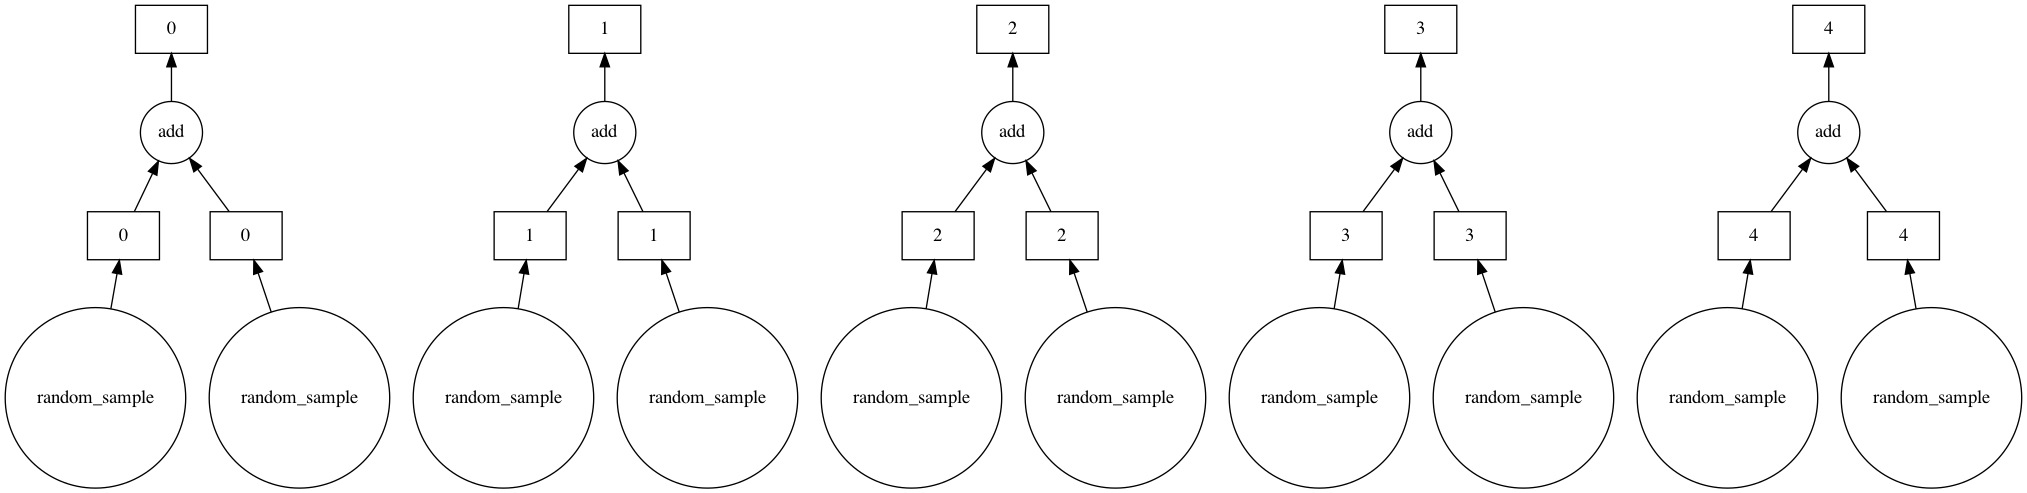

In [17]:
sum_x_y.visualize()

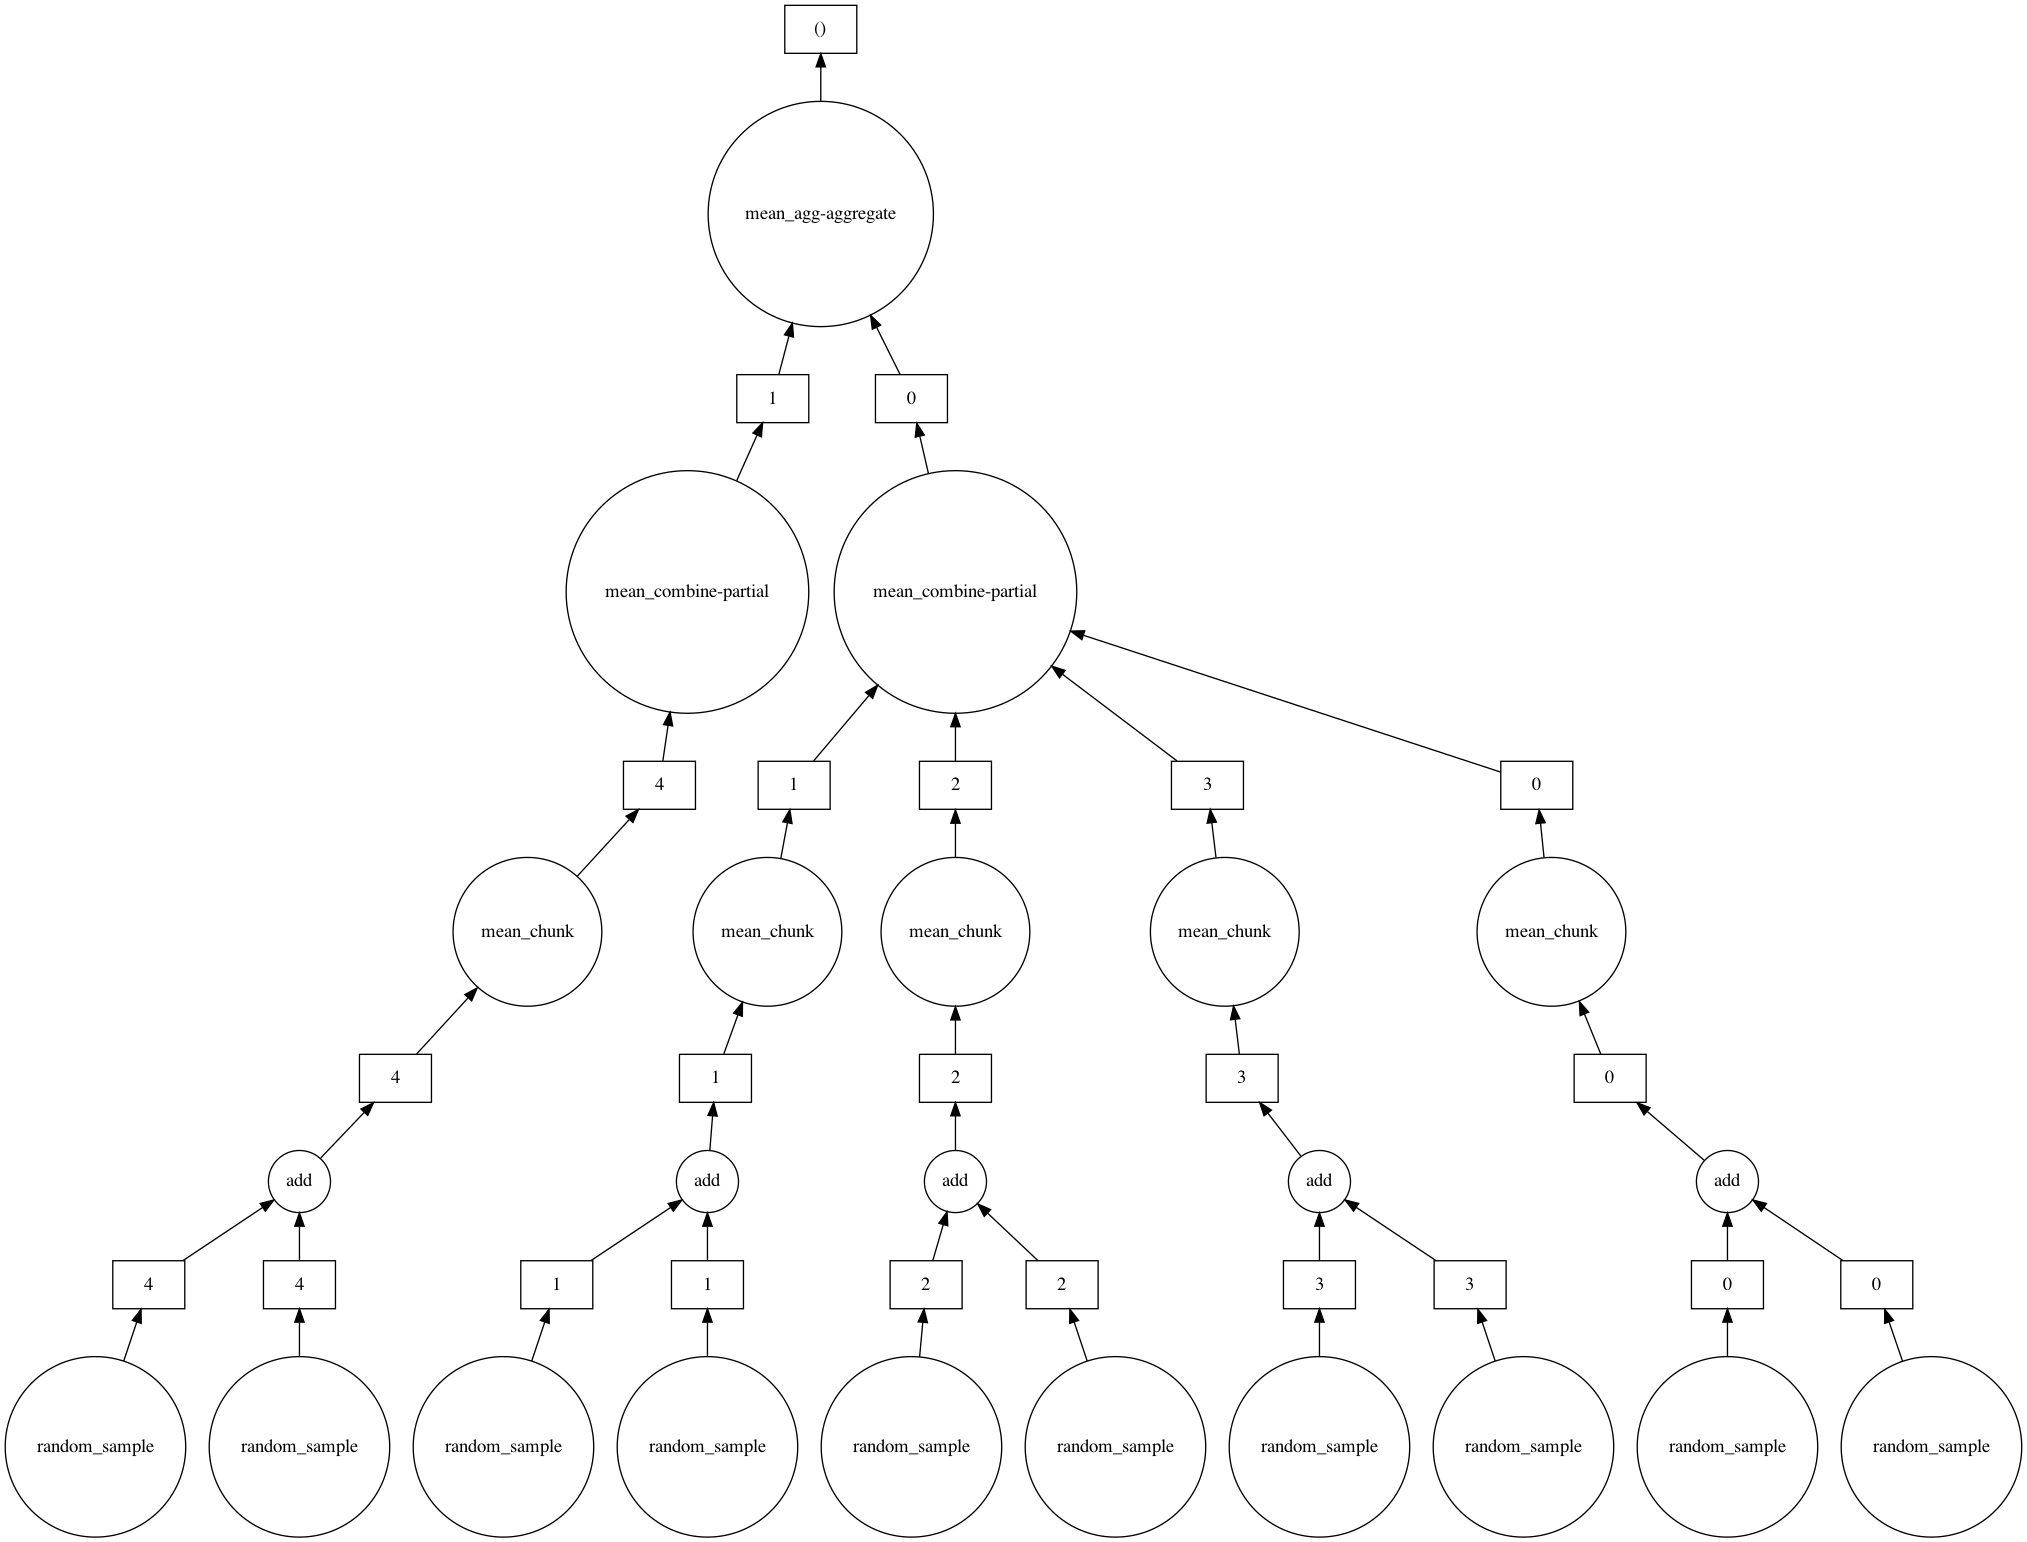

In [18]:
mean_x_y.visualize()

### 使用NumPy運算之效率

In [19]:
size_tuple = (18000,18000)
np_arr = np.random.randint(10, size=size_tuple)
np_arr2 = np.random.randint(10, size=size_tuple)

In [20]:
%time (((np_arr * 2).T)**2 + np_arr2 + 100).sum(axis=1).mean()

CPU times: user 5.39 s, sys: 1.13 s, total: 6.52 s
Wall time: 6.52 s


3933172.4571666666

### 使用Dask運算之效率

In [21]:
chunks_tuple = (500, 500)
da_arr = da.from_array(np_arr, chunks=chunks_tuple)
da_arr2 = da.from_array(np_arr2, chunks=chunks_tuple)

In [22]:
%time (((da_arr * 2).T)**2 + da_arr2 + 100).sum(axis=1).mean().compute()

CPU times: user 7.11 s, sys: 528 ms, total: 7.64 s
Wall time: 1.28 s


3933172.4571666666

## 範例:記憶體不足的運算

### NumPy 無法載入大量數據

In [23]:
size_tuple = (50000, 50000)
np_arr = np.random.randint(10, size=size_tuple)
np_arr2 = np.random.randint(10, size=size_tuple)

# you might have to KeyboardInterrupt this block if it takes too much time to execute

KeyboardInterrupt: 

In [23]:
size_tuple = (50000, 50000)
chunks_tuple = (5000, 5000)
da_arr = da.random.randint(10, size=size_tuple,
                           chunks=chunks_tuple)
da_arr2 = da.random.randint(10, size=size_tuple,
                            chunks=chunks_tuple)

In [24]:
%time (((da_arr * 2).T)**2 + da_arr2 + 100).sum(axis=1).mean().compute()

CPU times: user 3min 13s, sys: 41.5 s, total: 3min 55s
Wall time: 24.6 s


10924816.7083

In [25]:
da_arr.nbytes

20000000000

### Bytes 轉為 GB, 1Gb = 1e+9 bytes

In [26]:
da_arr.nbytes/1e+9

20.0

### 分散式運算

In [27]:
from dask import delayed
import dask

In [28]:
x = list(range(2, 20000, 2))
y = list(range(3, 30000, 3))
z = list(range(5, 50000, 5))

final_result = []

In [29]:
def do_something_1(x, y):
    return x + y + 2*x*y

def do_something_2(a, b):
    return a**3 - b**3

def do_something_3(p, q):
    return p*p + q*q

In [30]:
final_result = []
for i in range(0, len(x)):
    res_1 = delayed(do_something_1)(x[i], y[i])
    res_2 = delayed(do_something_2)(y[i], z[i])
    res_3 = delayed(do_something_3)(res_1, res_2)
    final_result.append(res_3)

final_sum = delayed(sum)(final_result)

In [31]:
with dask.config.set(scheduler='processes'):
    %time _ = final_sum.compute()

CPU times: user 3.86 s, sys: 716 ms, total: 4.58 s
Wall time: 4.2 s


In [32]:
with dask.config.set(scheduler='sync'):
    %time _ = final_sum.compute()

CPU times: user 927 ms, sys: 17.1 ms, total: 944 ms
Wall time: 943 ms


In [33]:
with dask.config.set(scheduler='threading'):
    %time _ = final_sum.compute()

CPU times: user 1.47 s, sys: 164 ms, total: 1.63 s
Wall time: 1.54 s


In [34]:
x = [2, 4, 6, 8]
y = [3, 6, 9, 12]
z = [5, 10, 15, 20]

final_result = []

In [35]:
import time

def do_something_1(x, y):
    time.sleep(4)
    return x + y + 2*x*y

def do_something_2(a, b):
    time.sleep(4)
    return a**3 - b**3

def do_something_3(p, q):
    time.sleep(4)
    return p*p + q*q

In [36]:
final_result = []
for i in range(0, len(x)):
    # Wrap the function calls inside delayed
    res_1 = delayed(do_something_1)(x[i], y[i])
    res_2 = delayed(do_something_2)(y[i], z[i])
    res_3 = delayed(do_something_3)(res_1, res_2)
    final_result.append(res_3)

final_sum = delayed(sum)(final_result)

In [37]:
with dask.config.set(scheduler='processes'):
    %time _ = final_sum.compute()

CPU times: user 32.1 ms, sys: 47.5 ms, total: 79.5 ms
Wall time: 8.31 s


In [38]:
with dask.config.set(scheduler='sync'):
    %time _ = final_sum.compute()

CPU times: user 3.94 ms, sys: 1.89 ms, total: 5.84 ms
Wall time: 48 s


In [39]:
with dask.config.set(scheduler='threading'):
    %time _ = final_sum.compute()

CPU times: user 4.47 ms, sys: 3.22 ms, total: 7.69 ms
Wall time: 8.01 s


In [23]:
from dask.distributed import Client
import dask.dataframe as df

client = Client(processes = False, threads_per_worker = 2, n_workers = 3, memory_limit = '4GB')

client

C:\Users\User\anaconda3\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 3516 instead
  warnings.warn(


Client Scheduler: inproc://192.168.1.103/18308/34 Dashboard: http://192.168.1.103:3516/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [24]:
import dask.array as da
x = da.random.random((10000, 10000, 10),chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10),chunks=(1000, 1000, 5))
z = (da.arcsin(x) + da.arccos(y)).sum()
z.compute()

1570807592.6630766